# Part1 演習
kaggleの[Predict Future Sales](https://www.kaggle.com/c/competitive-data-science-predict-future-sales/overview)を題材として、機械学習/構造データの演習

## 回帰モデル

In [1]:
## 必要なライブラリのインポート
import numpy as np
import pandas as pd
from itertools import product
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from xgboost import XGBClassifier
import time
import sys

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)

## データの読み込み
items = pd.read_csv('input/items.csv')
shops = pd.read_csv('input/shops.csv')
cats = pd.read_csv('input/item_categories.csv')
train = pd.read_csv('input/sales_train.csv')
# set index to ID to avoid droping it later*
test  = pd.read_csv('input/test.csv').set_index('ID')

## 外れ値処理

# 外れ値の除外
train = train[train.item_price < 100000]
train = train[train.item_cnt_day < 1001]

# 価格が負のアイテムの処理
median = train[(train.shop_id == 32) & (train.item_id == 2973) & (train.date_block_num == 4) & (train.item_price > 0)].item_price.median()
train.loc[train.item_price < 0, 'item_price'] = median

## データの前処理

# ショップIDの重複修正
# Якутск Орджоникидзе, 56*train.loc[train.shop_id == 0, 'shop_id'] = 57
test.loc[test.shop_id == 0, 'shop_id'] = 57
# Якутск ТЦ "Центральный"*train.loc[train.shop_id == 1, 'shop_id'] = 58
test.loc[test.shop_id == 1, 'shop_id'] = 58
# Жуковский ул. Чкалова 39м²*train.loc[train.shop_id == 10, 'shop_id'] = 11
test.loc[test.shop_id == 10, 'shop_id'] = 11

# ショップ名、カテゴリ名からの情報抽出とエンコード
shops.loc[shops.shop_name == 'Сергиев Посад ТЦ "7Я"', 'shop_name'] = 'СергиевПосад ТЦ "7Я"'
shops['city'] = shops['shop_name'].str.split(' ').map(lambda x: x[0])
shops.loc[shops.city == '!Якутск', 'city'] = 'Якутск'
shops['city_code'] = LabelEncoder().fit_transform(shops['city'])
shops = shops[['shop_id','city_code']]
cats['split'] = cats['item_category_name'].str.split('-')
cats['type'] = cats['split'].map(lambda x: x[0].strip())
cats['type_code'] = LabelEncoder().fit_transform(cats['type'])
# if subtype is nan then type*
cats['subtype'] = cats['split'].map(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
cats['subtype_code'] = LabelEncoder().fit_transform(cats['subtype'])
cats = cats[['item_category_id','type_code', 'subtype_code']] 

items.drop(['item_name'], axis=1, inplace=True)

## 月間売上データの作成
matrix = []
cols = ['date_block_num','shop_id','item_id']
for i in range(34):
    sales = train[train.date_block_num==i]
    matrix.append(np.array(list(product([i], sales.shop_id.unique(), sales.item_id.unique())), dtype='int16'))
    
matrix = pd.DataFrame(np.vstack(matrix), columns=cols)
matrix['date_block_num'] = matrix['date_block_num'].astype(np.int8)
matrix['shop_id'] = matrix['shop_id'].astype(np.int8)
matrix['item_id'] = matrix['item_id'].astype(np.int16)
matrix.sort_values(cols,inplace=True)

train['revenue'] = train['item_price'] *  train['item_cnt_day']

group = train.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_day': ['sum']})
group.columns = ['item_cnt_month']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=cols, how='left')
matrix['item_cnt_month'] = (matrix['item_cnt_month']
                                .fillna(0)
                                .clip(0,20) ) # NB clip target here*.astype(np.float16)

## テストセットの作成
test['date_block_num'] = 34
test['date_block_num'] = test['date_block_num'].astype(np.int8)
test['shop_id'] = test['shop_id'].astype(np.int8)
test['item_id'] = test['item_id'].astype(np.int16)

matrix = pd.concat([matrix, test], ignore_index=True, sort=False, keys=cols)
matrix.fillna(0, inplace=True) 

## 特徴量生成
matrix = pd.merge(matrix, shops, on=['shop_id'], how='left')
matrix = pd.merge(matrix, items, on=['item_id'], how='left')
matrix = pd.merge(matrix, cats, on=['item_category_id'], how='left')
matrix['city_code'] = matrix['city_code'].astype(np.int8)
matrix['item_category_id'] = matrix['item_category_id'].astype(np.int8)
matrix['type_code'] = matrix['type_code'].astype(np.int8)
matrix['subtype_code'] = matrix['subtype_code'].astype(np.int8)

def lag_feature(df, lags, col):
    tmp = df[['date_block_num','shop_id','item_id',col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = ['date_block_num','shop_id','item_id', col+'_lag_'+str(i)]
        shifted['date_block_num'] += i
        df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
    return df
    
matrix = lag_feature(matrix, [1,2,3,6,12], 'item_cnt_month')

## データセットの分割
X_train = matrix[matrix.date_block_num < 33].drop(['item_cnt_month'], axis=1)
Y_train = matrix[matrix.date_block_num < 33]['item_cnt_month']
X_valid = matrix[matrix.date_block_num == 33].drop(['item_cnt_month'], axis=1)
Y_valid = matrix[matrix.date_block_num == 33]['item_cnt_month']
X_test = matrix[matrix.date_block_num == 34].drop(['item_cnt_month'], axis=1)

/tmp/ipykernel_22713/2680781747.py:89: FutureWarning: The behavior of pd.concat with len(keys) != len(objs) is deprecated. In a future version this will raise instead of truncating to the smaller of the two sequences
  matrix = pd.concat([matrix, test], ignore_index=True, sort=False, keys=cols)


In [14]:
model = XGBRegressor(
    max_depth=8,
    n_estimators=500,  # 適切な数に調整
    min_child_weight=50,  # データサイズに応じて調整
    colsample_bytree=0.8,
    subsample=0.8,
    eta=0.07,  # 安定した学習率
    random_state=42,  # 再現性を高める
    seed=42,
    eval_metric="rmse",  # 初期化時に指定
    early_stopping_rounds=10
)

model.fit(
    X_train, 
    Y_train, 
    eval_set=[(X_train, Y_train), (X_valid, Y_valid)], 
    verbose=True
)

[0]	validation_0-rmse:1.20273	validation_1-rmse:1.11977
[1]	validation_0-rmse:1.17365	validation_1-rmse:1.09866
[2]	validation_0-rmse:1.14797	validation_1-rmse:1.07904
[3]	validation_0-rmse:1.12556	validation_1-rmse:1.06249
[4]	validation_0-rmse:1.10491	validation_1-rmse:1.04760
[5]	validation_0-rmse:1.08692	validation_1-rmse:1.03467
[6]	validation_0-rmse:1.07083	validation_1-rmse:1.02365
[7]	validation_0-rmse:1.06054	validation_1-rmse:1.01497
[8]	validation_0-rmse:1.05176	validation_1-rmse:1.00822
[9]	validation_0-rmse:1.04392	validation_1-rmse:1.00235
[10]	validation_0-rmse:1.03700	validation_1-rmse:0.99704
[11]	validation_0-rmse:1.02613	validation_1-rmse:0.99047
[12]	validation_0-rmse:1.01665	validation_1-rmse:0.98424
[13]	validation_0-rmse:1.01186	validation_1-rmse:0.98023
[14]	validation_0-rmse:1.00422	validation_1-rmse:0.97568
[15]	validation_0-rmse:0.99730	validation_1-rmse:0.97164
[16]	validation_0-rmse:0.99116	validation_1-rmse:0.96807
[17]	validation_0-rmse:0.98560	validation

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=10,
             enable_categorical=False, eta=0.07, eval_metric='rmse',
             feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
             max_leaves=None, min_child_weight=50, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=500,
             n_jobs=None, num_parallel_tree=None, ...)

In [15]:
Y_pred = model.predict(X_valid).clip(0, 20) 
rmse = np.sqrt(mean_squared_error(Y_valid, Y_pred))
print(f'Validation RMSE: {rmse}')

Validation RMSE: 0.9261811668304486


In [16]:
Y_test = model.predict(X_test).clip(0, 20)
submission = pd.DataFrame({
'ID': test.index,
'item_cnt_month': Y_test
})
submission.to_csv('xgb_submission.csv', index=False)

## 分類モデル

In [2]:
def categorize_sales(x):
    if x == 0:
        return 'no_sales'
    elif x <= 5:
        return 'low'
    elif x <= 15:
        return 'medium'
    else:
        return 'high'

# 目的変数をカテゴリに変換
Y_train = Y_train.apply(categorize_sales)
Y_valid = Y_valid.apply(categorize_sales)

In [3]:
import lightgbm

model_cl = lightgbm.LGBMClassifier(
    max_depth=8,
    n_estimators=500,  # 適切な数に調整
    min_child_weight=50,  # データサイズに応じて調整
    colsample_bytree=0.8,
    subsample=0.8,
    eta=0.07,  # 安定した学習率
    random_state=42,  # 再現性を高める
    seed=42,
    eval_metric="multi_logloss",  # 初期化時に指定
    early_stopping_rounds=10
)

model_cl.fit(
    X_train,
    Y_train,
    eval_set=[(X_train, Y_train), (X_valid, Y_valid)]
)

[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] learning_rate is set=0.1, eta=0.07 will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] early_stopping_round is set=10, early_stopping_rounds=10 will be ignored. Current value: early_stopping_round=10
[LightGBM] [Warning] seed is set=42, random_state=42 will be ignored. Current value: seed=42
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] learning_rate is set=0.1, eta=0.07 will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] seed is set=42, random_state=42 will be ignored. Current value: seed=42
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.231658 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 650
[LightGBM] [Info] Number of data points in the train set: 10675632, number of used features: 12
[LightGBM

LGBMClassifier(colsample_bytree=0.8, early_stopping_rounds=10, eta=0.07,
               eval_metric='multi_logloss', max_depth=8, min_child_weight=50,
               n_estimators=500, random_state=42, seed=42, subsample=0.8)

In [5]:
from sklearn.metrics import classification_report, confusion_matrix

Y_pred = model_cl.predict(X_valid)
print(classification_report(Y_valid, Y_pred))
print(confusion_matrix(Y_valid, Y_pred))

[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] learning_rate is set=0.1, eta=0.07 will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] seed is set=42, random_state=42 will be ignored. Current value: seed=42
              precision    recall  f1-score   support

        high       0.58      0.29      0.38       358
         low       0.63      0.21      0.31     29869
      medium       0.42      0.16      0.24      1244
    no_sales       0.89      0.98      0.94    206701

    accuracy                           0.88    238172
   macro avg       0.63      0.41      0.47    238172
weighted avg       0.86      0.88      0.85    238172

[[   103     25     36    194]
 [    20   6189    210  23450]
 [    40    501    205    498]
 [    15   3084     40 203562]]


## PCA

In [6]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# lag特徴量の列を削除（Nanが多いため）
X_train = X_train.drop(columns=['item_cnt_month_lag_1', 'item_cnt_month_lag_2', 
                                'item_cnt_month_lag_3', 'item_cnt_month_lag_6', 
                                'item_cnt_month_lag_12'])
X_valid = X_valid.drop(columns=['item_cnt_month_lag_1', 'item_cnt_month_lag_2', 
                                'item_cnt_month_lag_3', 'item_cnt_month_lag_6', 
                                'item_cnt_month_lag_12'])
X_test = X_test.drop(columns=['item_cnt_month_lag_1', 'item_cnt_month_lag_2', 
                              'item_cnt_month_lag_3', 'item_cnt_month_lag_6', 
                              'item_cnt_month_lag_12'])

# 特徴量のスケーリング
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

In [7]:
# PCAの適用
pca = PCA(n_components=0.95)  # 寄与率の合計が95%になるまでの主成分を抽出
X_train_pca = pca.fit_transform(X_train_scaled)
X_valid_pca = pca.transform(X_valid_scaled)
X_test_pca = pca.transform(X_test_scaled)

In [13]:
contribution_rates = [0.5, 0.8, 0.9, 0.95, 0.99]  # 寄与率のリスト

for rate in contribution_rates:
    pca = PCA(n_components=rate)
    X_train_pca_validate = pca.fit_transform(X_train_scaled)
    print(f"寄与率 {rate*100}% の場合の次元数: {X_train_pca_validate.shape[1]}")

寄与率 50.0% の場合の次元数: 2
寄与率 80.0% の場合の次元数: 4
寄与率 90.0% の場合の次元数: 5
寄与率 95.0% の場合の次元数: 5
寄与率 99.0% の場合の次元数: 6


In [9]:
model_cl_pca = lightgbm.LGBMClassifier(
    max_depth=8,
    n_estimators=500,  # 適切な数に調整
    min_child_weight=50,  # データサイズに応じて調整
    colsample_bytree=0.8,
    subsample=0.8,
    eta=0.07,  # 安定した学習率
    random_state=42,  # 再現性を高める
    seed=42,
    eval_metric="multi_logloss",  # 初期化時に指定
    early_stopping_rounds=10
)

model_cl_pca.fit(
    X_train_pca,
    Y_train,
    eval_set=[(X_train_pca, Y_train), (X_valid_pca, Y_valid)]
)

[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] learning_rate is set=0.1, eta=0.07 will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] early_stopping_round is set=10, early_stopping_rounds=10 will be ignored. Current value: early_stopping_round=10
[LightGBM] [Warning] seed is set=42, random_state=42 will be ignored. Current value: seed=42
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] learning_rate is set=0.1, eta=0.07 will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] seed is set=42, random_state=42 will be ignored. Current value: seed=42
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.046673 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 10675632, number of used features: 5
[LightGBM

LGBMClassifier(colsample_bytree=0.8, early_stopping_rounds=10, eta=0.07,
               eval_metric='multi_logloss', max_depth=8, min_child_weight=50,
               n_estimators=500, random_state=42, seed=42, subsample=0.8)

In [10]:
from sklearn.metrics import classification_report, confusion_matrix

Y_pred_pca = model_cl_pca.predict(X_valid_pca)
print(classification_report(Y_valid, Y_pred_pca))
print(confusion_matrix(Y_valid, Y_pred_pca))

[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] learning_rate is set=0.1, eta=0.07 will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] seed is set=42, random_state=42 will be ignored. Current value: seed=42


/app/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/app/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/app/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

        high       1.00      0.02      0.04       358
         low       0.51      0.02      0.04     29869
      medium       0.00      0.00      0.00      1244
    no_sales       0.87      1.00      0.93    206701

    accuracy                           0.87    238172
   macro avg       0.59      0.26      0.25    238172
weighted avg       0.82      0.87      0.81    238172

[[     7     30      0    321]
 [     0    603      0  29266]
 [     0    102      0   1142]
 [     0    449      0 206252]]


## クラスタリング


In [14]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

## データ作成
# items と cats を結合
items_extended = pd.merge(items, cats, on='item_category_id', how='left')

# 商品ごとの平均価格を計算
average_price = train.groupby('item_id')['item_price'].mean().reset_index()
average_price.columns = ['item_id', 'average_price']

# 商品情報と価格情報を結合
items_extended = pd.merge(items_extended, average_price, on='item_id', how='left')

## 特徴量のスケーリング
features = items_extended[['average_price']]

scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Nanのある行を削除
features_scaled = features_scaled[~np.isnan(features_scaled).any(axis=1)]
items_extended = items_extended[~features.isna().any(axis=1)]

In [16]:
# K-means クラスタリング
kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(features_scaled)

In [17]:
silhouette_avg = silhouette_score(features_scaled, clusters)
print(f'Silhouette Score: {silhouette_avg}')

# クラスタリング結果の追加
items_extended['cluster'] = clusters

# クラスタ毎のデータ分析
print(items_extended.groupby('cluster').mean())

Silhouette Score: 0.7342297756261653
              item_id  item_category_id  type_code  subtype_code  \
cluster                                                            
0        11375.309192         45.681871  11.340503     19.011648   
1         9741.953488         41.116279   8.976744     22.023256   
2         8235.102616         49.064386  10.488934     27.981891   
3        10008.130178         35.893491   8.088757     21.952663   
4        10266.187217         49.233555  10.882024     28.290812   

         average_price  
cluster                 
0           329.060992  
1         29131.013082  
2          4705.262898  
3         11556.375183  
4          1706.484440  


### GMMによるクラスタリング

In [18]:
import pandas as pd
import numpy as np
from sklearn.mixture import GaussianMixture as GMM
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

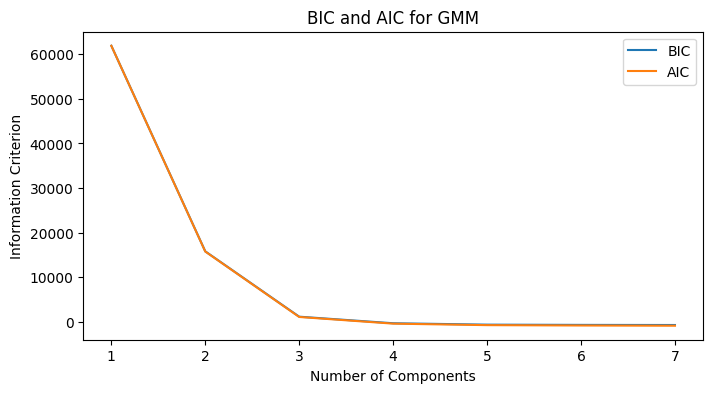

In [25]:
# GMMによるクラスタリング
bic = []
aic = []
n_components_range = range(1, 8)

# BICとAICを計算して最適なクラスタ数を選定
for n_components in n_components_range:
    gmm = GMM(n_components=n_components, random_state=42)
    gmm.fit(features_scaled)
    bic.append(gmm.bic(features_scaled))
    aic.append(gmm.aic(features_scaled))

# BICとAICのプロット
plt.figure(figsize=(8, 4))
plt.plot(n_components_range, bic, label='BIC')
plt.plot(n_components_range, aic, label='AIC')
plt.xlabel('Number of Components')
plt.ylabel('Information Criterion')
plt.legend()
plt.title('BIC and AIC for GMM')
plt.show()

In [ ]:
# 最適なクラスタ数を選択(目視で選択)
optimal_n_components = 4
print(f'Optimal number of components by BIC: {optimal_n_components}')

# 最適なクラスタ数でGMMを再度適用
gmm_optimal = GMM(n_components=optimal_n_components, random_state=42)
clusters_gmm = gmm_optimal.fit_predict(features_scaled)

Optimal number of components by BIC: 4


In [33]:
silhouette_avg = silhouette_score(features_scaled, clusters_gmm)
print(f'Silhouette Score: {silhouette_avg}')

# クラスタリング結果の追加
items_extended['cluster'] = clusters_gmm

# クラスタ毎のデータ分析
print(items_extended.groupby('cluster').mean())

Silhouette Score: 0.6545495036326153
              item_id  item_category_id  type_code  subtype_code  \
cluster                                                            
0        11524.714265         45.395120  11.430092     17.279279   
1         9444.971530         40.167260   8.861210     23.526690   
2        10634.846372         48.683929  11.066425     27.519597   
3         8690.377674         45.390698   9.832558     27.411163   

         average_price  
cluster                 
0           231.967881  
1         13175.495792  
2          1121.662235  
3          3311.921592  
